In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Resource modeling in CHIME - Part 1 of n
## Understanding the current approach
The goal for this notebook is to try to help people (including myself) better understand the concepts, math and code behind the resource modeling in [CHIME](https://github.com/CodeForPhilly/chime).

This is my interpetation of the model based on the available documentation, discussions on the [#chime-analysis Slack channel](https://codeforphilly.org/chat?channel=chime-analysis), exploring and commenting on [Issues](https://github.com/CodeForPhilly/chime/issues), discussions with colleagues and [my experience in using it](https://github.com/misken/c19). I am **not** one of the CHIME developers. You can find out more about me at my [faculty page](http://www.sba.oakland.edu/faculty/isken/) and my [hselab tech blogging](http://hselab.org/) site.

This notebook is a (hopefully) pleasant mix of modeling concepts, math, code and output. I hope you find it helpful. I don't know the value of $n$ but it is at least 2. 

**Note:** This notebook was created on 2020-04-03 based on CHIME code as of that date.

## Simulate a base scenario

Here are a set of [CHIME input values](https://code-for-philly.gitbook.io/chime/what-is-chime/parameters) for the current model.

    --current-hospitalized 658
    --doubling-time 3.61
    --hospitalized-day 7
    --hospitalized-rate 0.025
    --icu-days 9
    --icu-rate 0.0075
    --market_share 0.32
    --infectious-days 14
    --n-days 120
    --relative-contact-rate 0.31
    --population 5026226
    --ventilated-day 10
    --ventilated-rate 0.005

Let's run the simulation using `sim_chime_scenario_runner`. I wrote this to make it a little easier to use the CHIME model for exploring and managing a bunch of different scenarios. See [using_sim_chime_scenario_runner.ipynb](https://github.com/misken/c19/blob/master/mychime/scenario_runner/using_sim_chime_scenario_runner.ipynb). 

> You do **NOT** need to get or use this tool. It's used here purely just to run one simulation. Everything else in this notebook is based on standard CHIME output files and the official CHIME code.

The basic steps are:

* import the `sim_chime_scenario_runner` module
* specify scenario name (if you don't, default is current datetime)
* create a `penn_chime.Parameters` object from the input config file using `create_params_from_file`
* call `sim_chime` to run the simulation using the CHIME `SimSirModel` class  and return results dictionary
* do whatever you want with the results
  - csv and json outputs just happen for command line use as in penn_chime cli.py
  - `write_results` function will write out all dataframes (to csv) and dicts (to json)
  - or selectively do whatever you want with components of the results dictionary
  
**NOTE:** This scenario runner is using the version of CHIME that you have installed/cloned on your system and that you have obtained from https://github.com/CodeForPhilly/chime. The scenario runner is just a "wrapper"; it does **NOT** contain the `penn_chime` module - it imports it.

In [3]:
# Import the scenario runner. It will import various penn_chime artifacts.
import sim_chime_scenario_runner as runner

In [4]:
scenario = 'base_dt361'  # This string will get prepended to all output files
p = runner.create_params_from_file("tests/dt361.cfg")  # Returns a penn_chime Parameters object
type(p)

penn_chime.parameters.Parameters

Let's look at the parameter values. The Python `vars` function will return a dictionary version of the `Parameters` object `p`. You will recognize the various inputs from above. Notice that there are some custom object types (i.e. classes) in there. For example, the `Disposition` class contains both the rate of patients requiring that resource as well as the length of stay (how long the resources was used).

In [5]:
vars(p)

{'current_hospitalized': 658,
 'infectious_days': 14,
 'market_share': 0.32,
 'n_days': 120,
 'relative_contact_rate': 0.31,
 'population': 5026226,
 'hospitalized': Disposition(rate=0.025, days=7),
 'icu': Disposition(rate=0.0075, days=9),
 'ventilated': Disposition(rate=0.005, days=10),
 'current_date': datetime.date(2020, 4, 6),
 'date_first_hospitalized': None,
 'doubling_time': 3.61,
 'mitigation_date': None,
 'max_y_axis': None,
 'recovered': 0,
 'region': None,
 'labels': {'hospitalized': 'Hospitalized',
  'icu': 'ICU',
  'ventilated': 'Ventilated',
  'day': 'Day',
  'date': 'Date',
  'susceptible': 'Susceptible',
  'infected': 'Infected',
  'recovered': 'Recovered'},
 'dispositions': {'hospitalized': Disposition(rate=0.025, days=7),
  'icu': Disposition(rate=0.0075, days=9),
  'ventilated': Disposition(rate=0.005, days=10)}}

## Current patient flow model in CHIME

The current model strikes a balance between complexity of the model and complexity of inputs required of the user. CHIME models three, somewhat overlapping, resources:

* hospital beds - of any type (e.g. regular, step-down, ICU, etc); it's one big bucket of beds,
* ICU beds - these beds are included in the hospital beds,
* ventilators - anyone using a ventilator is assumed to also be in an ICU bed and thus, in a hospital bed.

Before getting into the details of how use of these resources is modeled, let's step back and see how the arrival streams (or admission rates) are modeled.


### The underlying SIR model

This is a [standard epidemiological *compartment model*](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). There are a ton of resources available to learn more about this model and I'm just going to mention a few key things that are directly relevant to resource modeling in CHIME.

* the version of SIR used in CHIME is deterministic (no random variables) and can be viewed as way to estimate average compartment size over time based on a set of differential equations modeling the flow of people between the susceptible ($S$), infectious ($I$) and removed ($R$) compartments, or stages.
* in order to simulate this SIR model, time is discretized with the clock ticking in whole days.
* the SIR model is simulated in a Python class named `SimSirModel` that takes as inputs the set of parameter values shown above and generates (among other things) a pandas `DataFrame` called `sim_sir_w_date_df` containing the simulated occupancy of the $S$, $I$ and $R$ compartments. 
* The $I$ and $R$ values will provide the basis for estimating resource use.

Let's run the model so that we can see exactly what this data frame looks like and see some of the other outputs from `SimSirModel`. The `runner.sim_chime` function takes a scenario ID and `Parameters` object as inputs and returns a tuple containing the `penn_chime.models.SimSirModel` model object as well as a dictionary of results (details were described near top of this notebook).



In [6]:
model, results = runner.sim_chime(scenario, p)

2020-04-06 10:45:08,717 - penn_chime.models - INFO - Using doubling_time: 3.61
2020-04-06 10:45:08,743 - penn_chime.models - INFO - Set i_day = 34
2020-04-06 10:45:08,743 - penn_chime.models - INFO - Estimated date_first_hospitalized: 2020-03-03; current_date: 2020-04-06; i_day: 34
2020-04-06 10:45:08,744 - penn_chime.models - INFO - len(np.arange(-i_day, n_days+1)): 155
2020-04-06 10:45:08,745 - penn_chime.models - INFO - len(raw_df): 155


Here are the keys in the `results` dictionary.

In [7]:
results.keys()

dict_keys(['scenario', 'input_params_dict', 'intermediate_variables_dict', 'sim_sir_w_date_df', 'dispositions_df', 'admits_df', 'census_df'])

We'll get to all of these eventually, but let's just look at the `sim_sir_w_date_df` dataframe. It's the primary output of the SIR model. 

> All of the dataframes in the results dictionary are the exact dataframes created by the `penn_chime` code.

In [8]:
sim_sir_w_date_df = results['sim_sir_w_date_df']
sim_sir_w_date_df.head()

,day,date,susceptible,infected,recovered
0,-34,2020-03-03,5.026101e+06,125.000000,0.000000
1,-33,2020-03-04,5.026066e+06,151.459955,8.928571
2,-32,2020-03-05,5.026023e+06,183.520642,19.747140
3,-31,2020-03-06,5.025971e+06,222.367416,32.855757
4,-30,2020-03-07,5.025908e+06,269.436440,48.739144


Note that the CHIME model ["back forecasted" to the date of first hospital admit](https://code-for-philly.gitbook.io/chime/what-is-chime/parameters#date-of-the-first-hospitalized-case-checkbox) based on the doubling time input value we provided. The values in the last three columns are the projected number of people in the $S$, $I$ and $R$ compartments based on the inputs we provided and the dynamics of spread modeled by SIR models. Let's plot these columns. We will first melt the dataframe to get it into *long form*.

In [9]:
sim_sir_long = pd.melt(sim_sir_w_date_df, 
  id_vars=['day', 'date'],
                       value_vars=['susceptible', 'infected', 'recovered'],
                       var_name='compartment', value_name='cases')

sim_sir_long.head()

,day,date,compartment,cases
0,-34,2020-03-03,susceptible,5.026101e+06
1,-33,2020-03-04,susceptible,5.026066e+06
2,-32,2020-03-05,susceptible,5.026023e+06
3,-31,2020-03-06,susceptible,5.025971e+06
4,-30,2020-03-07,susceptible,5.025908e+06


In [10]:
sim_sir_long.iloc[220:225, :]

,day,date,compartment,cases
220,31,2020-05-07,infected,1.225620e+06
221,32,2020-05-08,infected,1.264846e+06
222,33,2020-05-09,infected,1.299096e+06
223,34,2020-05-10,infected,1.327982e+06
224,35,2020-05-11,infected,1.351230e+06


In [11]:
sim_sir_long.tail()

,day,date,compartment,cases
460,116,2020-07-31,recovered,4.601905e+06
461,117,2020-08-01,recovered,4.604380e+06
462,118,2020-08-02,recovered,4.606716e+06
463,119,2020-08-03,recovered,4.608920e+06
464,120,2020-08-04,recovered,4.611000e+06


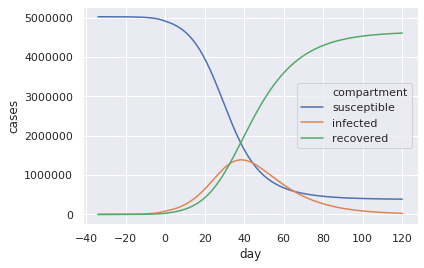

In [12]:
sns.lineplot(x='day', y='cases', hue='compartment', 
             data=sim_sir_long);

Remember, these are numbers of people in the total modeled population ($P$) in $S$, $I$ and $R$. Conservation of people holds and $S + I + R = P$.

## Translating *I* and *R* --> resource use

This will take a few distinct steps.

### Step 1 - Dispositions
The first step is to go from $I$ and $R$ to number of people requiring hospitalization, ICU care, and ventilator care. In Python and model terms, we need to go from `sim_sir_w_date_df` to `dispositions_df`. 

In [13]:
dispositions_df = results['dispositions_df']
dispositions_df[30:40]

,day,date,hospitalized,icu,ventilated
30,-4,2020-04-02,420.075428,126.022628,84.015086
31,-3,2020-04-03,508.000269,152.400081,101.600054
32,-2,2020-04-04,614.042726,184.212818,122.808545
33,-1,2020-04-05,741.811484,222.543445,148.362297
34,0,2020-04-06,895.577004,268.673101,179.115401
35,1,2020-04-07,1023.081937,306.924581,204.616387
36,2,2020-04-08,1165.369664,349.610899,233.073933
37,3,2020-04-09,1324.004490,397.201347,264.800898
38,4,2020-04-10,1500.678615,450.203584,300.135723
39,5,2020-04-11,1697.212924,509.163877,339.442585


Consider the **hospitalized** column - similar logic will apply to **icu** and **ventilated**. At each time step, we need to compute the number of **newly infected people** (let's call it $i_t$) - these are the *potential hospital admissions*. In essence, the CHIME model assumes that a fraction of all new potential hospital admissions at each time step immediately become hospitalized.  

At first, it might seem that all we need to do to compute $i_t$ is to compute $I_t - I_{t-1}$. However, it's a little trickier than that. The value of $I_t$ is composed of:

* people who were infected at time $(t-1)$, $I_{t-1}$,
* minus those who transitioned from $I$ to $R$ - let's call it $r_t$, 
* plus the number of newly infected people, $i_t$.

So, 

$$
I_t = I_{t-1} - r_t + i_t 
$$

and then,

$$
i_t = I_t - I_{t-1} + r_t
$$

But, $r_t$, the new transitions from $I$ to $R$, is just $R_t - R_{t-1}$. Remember, $R$ is an "accumulating state" and represents the cumulative number of transitions from $I$ to $R$ up through time $t$. We can rewrite the previous equation as

$$
i_t = (I_t - I_{t-1}) + (R_t - R_{t-1})
$$

which might be paraphrased as "newly infected is equal to the change in $I$ plus the change in $R$. Now, let's regroup the terms and rewrite the equation for $i_t$ as

$$
i_t = (I_t + R_t) - (I_{t-1} + R_{t-1})
$$

or 

$$
i_t = S_t^{'} - S_{t-1}^{'}
$$

The value of $S_t^{'} = (I_t + R_t)$ is the subset of the population that is no longer in the susceptible ($S$) bucket at time $t$, but is in $I$ or $R$ instead. So, $P_t = S_t + S_t^{'}$. Everyone is either in $S$ or not in $S$. 

We can interpret $i_t$ as the **new** group of potential resource users at time $t$.

Finally, we can get to *dispositions* by multiplying $S_t^{'}$ by the appropriate resource use rate for hospitalization ($h=$ `hospitalized-rate`) and the hospital market share ($m =$ `market-share`). For hospitalizations,

$$
D_t^{H} = h \cdot m \cdot S_t^{'}
$$

$D_t^{H}$ is exactly what is contained in the **hospitalized** column of the `dispositions_df` dataframe we saw earlier. Let's check our thinking by computing dispositions from the raw SIR output and comparing it to `dispositions_df`.

In [14]:
hosp_market_share = p.market_share
hospitalized_fraction = p.hospitalized.rate
print('Market share: {:.3f}\nFraction of infected needing hospitalization: {:.4f}'.format(
    hosp_market_share, hospitalized_fraction))


Market share: 0.320
Fraction of infected needing hospitalization: 0.0250


In [15]:
# Compute D = (I + R) * m * h
dispos_hosp = (sim_sir_w_date_df.infected + sim_sir_w_date_df.recovered) * hosp_market_share * hospitalized_fraction

# Create mini DataFrame of our computed D and the actual D from dispositions_df. 
# The two columns should be equal.
dispos_hosp.name = 'num_hospitalized'  # Give Series a nice name
pd.DataFrame({dispos_hosp.name: dispos_hosp, 
              'hospitalized': dispositions_df.hospitalized}, index=None).head()



,num_hospitalized,hospitalized
0,1.000000,1.000000
1,1.283108,1.283108
2,1.626142,1.626142
3,2.041785,2.041785
4,2.545405,2.545405


Looks good, but let's double check that they contain equal values by making an assertion.

In [16]:
pd.testing.assert_series_equal(dispositions_df['hospitalized'], dispos_hosp,
                                        check_names=False)

Great. 

> **IMPORTANT** The above logic holds for ICU and ventilator use as well since the user inputs, `icu-rate` and `ventilated-rate` are expressed as percentages of the total population. So, let's use $D_t^{C}$ and $D_t^{V}$ to represent dispositions for icu and ventilated patients.

In fact, we can actually see all of the above math and logic play out in the following function in `penn_chime.models`. I've taken the liberty of adding a few additional comments.

```python
    def build_dispositions_df(
        raw_df: pd.DataFrame,
        rates: Dict[str, float],
        market_share: float,
        current_date: datetime,
    ) -> pd.DataFrame:
        """Build dispositions dataframe of patients adjusted by rate and market_share."""
        patients = raw_df.infected + raw_df.recovered    # Here is S' = I + R
        day = raw_df.day
        return pd.DataFrame({
            "day": day,
            "date": day.astype('timedelta64[D]') + np.datetime64(current_date),
            **{
                key: patients * rate * market_share # Use rate for hospital, icu, or vent
                for key, rate in rates.items()      # Iterating over hospital, icu, vent
            }
        })
```

### Step 2- Admits
We saw above that $i_t = S_t^{'} - S_{t-1}^{'}$ is the number of new potential resource users. Since dispositions is just a rescaled version of $S_t^{'}$, we can compute the estimated number of new admits by

$$
A_t = D_t - D_{t-1}
$$

Of course, we do this separately for hospitalizations, icu, and vents. Here's the annotated function from `penn_chime.models`.

```python
def build_admits_df(dispositions_df: pd.DataFrame) -> pd.DataFrame:
    """Build admits dataframe from dispositions."""
    admits_df = dispositions_df - dispositions_df.shift(1)  #D_{t} - D_{t-1}
    admits_df.day = dispositions_df.day
    admits_df.date = dispositions_df.date
    return admits_df
```

In [17]:
results['admits_df'].head()

,day,date,hospitalized,icu,ventilated
0,-34,2020-03-03,NaN,NaN,NaN
1,-33,2020-03-04,0.283108,0.084932,0.056622
2,-32,2020-03-05,0.343034,0.102910,0.068607
3,-31,2020-03-06,0.415643,0.124693,0.083129
4,-30,2020-03-07,0.503619,0.151086,0.100724


In [18]:
results['admits_df'][30:45]

,day,date,hospitalized,icu,ventilated
30,-4,2020-04-02,72.843830,21.853149,14.568766
31,-3,2020-04-03,87.924841,26.377452,17.584968
32,-2,2020-04-04,106.042456,31.812737,21.208491
33,-1,2020-04-05,127.768758,38.330627,25.553752
34,0,2020-04-06,153.765520,46.129656,30.753104
35,1,2020-04-07,127.504933,38.251480,25.500987
36,2,2020-04-08,142.287727,42.686318,28.457545
37,3,2020-04-09,158.634826,47.590448,31.726965
38,4,2020-04-10,176.674125,53.002237,35.334825
39,5,2020-04-11,196.534309,58.960293,39.306862


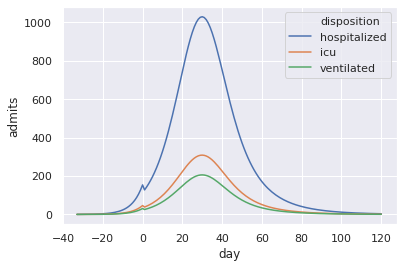

In [19]:
admits_df = results['admits_df']
admits_long = pd.melt(admits_df, 
  id_vars=['day', 'date'],
                       value_vars=['hospitalized', 'icu', 'ventilated'],
                       var_name='disposition', value_name='admits')


sns.lineplot(x='day', y='admits', hue='disposition', 
             data=admits_long);

Well, that was easy. On to census.

### Step 3 - Census
Remember, this is a deterministic model. The user is asked to provide three average length of stay (ALOS) values:

* `hospitalized-day` - average time spent in the hospital by **any covid-19 patient, in any bed type**.
* `icu days` - average time spent in an ICU bed **only for those covid-19 patients who went to an ICU**.
* `ventilated-day` - average time spent on a ventilator **only for those covid-19 patients who were ventilated**

**IMPORTANT** - see the Documentation on user inputs for ALOS at https://code-for-philly.gitbook.io/chime/what-is-chime/parameters#length-of-stay.

### Assumptions and interpretations

There are some other important assumptions and interpretations regarding the interplay between these ALOS values for the different resources.

$$
H \subset C \subset V
$$

Ventilated patients are a subset of ICU patients and ICU patients are a subset of hospitalized patients. This keeps things simpler in the sense that we are estimating average census values for each resource independently by, essentially, multiplying the arrival rate (average number of new dispositions per day) by the appropriate ALOS value (the Python code does this in a different manner but the result is the same). A couple of points:

* for those of you with a bit of queueing or "process physics" knowledge, this is just [Little's Law](https://en.wikipedia.org/wiki/Little%27s_law).
* this model is not in any way looking at details of patient flow patterns such as the fact that patients may take different paths through the hospital:
  - Regular bed --> Discharge
  - Regular bed --> ICU --> Regular/step down --> Discharge
  - Regular bed --> ICU --> Discharge
  - ICU --> Discharge
  - ICU --> Regular/step down --> Discharge
  - Step Down --> Discharge
  - ... etc.
* there is no explicit consideration of capacity limits,
* there is no explicit consideration of parameter uncertainty or stochastic processes.


This is **not** a criticism of the model. All models are approximations, models have varying purposes and there are always tradeoffs. The CHIME model balances complexity, number and availability of user inputs, and its goal of being a quick, rough approximation of resource implications during early to middle stages (i.e. before capacity becomes the limiting factor) of a spreading virus. As capacity becomes more of an issue, there will likely be a need for additional models. Discrete event patient flow simulation models are one of the likely candidates. If interested, you can see simple examples of such models using the Python [simpy](https://simpy.readthedocs.io/en/latest/) package in two blog posts I did, [here](http://hselab.org/simpy-getting-started-patient-flow-modeling.html) and [here](http://hselab.org/simpy-first-oo-patflow-model.html).

### Computing average census values
Census can be computed for each resource independently using the `admits_df` DataFrame and the appropriate ALOS value for the resource. Here's the annotated code.

```python
def build_census_df(
    admits_df: pd.DataFrame,
    lengths_of_stay: Dict[str, int],
) -> pd.DataFrame:
    """Average Length of Stay for each disposition of COVID-19 case (total guesses)"""
    return pd.DataFrame({
        'day': admits_df.day,
        'date': admits_df.date,
        **{
            key: (                       # See below for illustration of this computation
                admits_df[key].cumsum()
                - admits_df[key].cumsum().shift(los).fillna(0)
            )
            for key, los in lengths_of_stay.items()
        }
    })
```

Ok, the key line is

```python
admits_df[key].cumsum()
                - admits_df[key].cumsum().shift(los).fillna(0)
```

Let's see how this works.

In [20]:
# Grab the dataframes we need
admits_df = results['admits_df']
census_df = results['census_df']

# Let's look at hospitalized 
key = 'hospitalized'
los = 7

# Make a mini DataFrame with columns to illustrate the computation
admits = admits_df[key]
census = census_df[key]
cum_admits = admits_df[key].cumsum()
shifted_cum_admits = admits_df[key].cumsum().shift(los).fillna(0)

census_demo_df = pd.DataFrame({
    'admits': admits,
    'cum_admits': cum_admits,
    'shifted_cum_admits': shifted_cum_admits,
    'census_computation': cum_admits - shifted_cum_admits,
    'census_chime': census
})

census_demo_df.head(15)

,admits,cum_admits,shifted_cum_admits,census_computation,census_chime
0,NaN,NaN,0.000000,NaN,NaN
1,0.283108,0.283108,0.000000,0.283108,0.283108
2,0.343034,0.626142,0.000000,0.626142,0.626142
3,0.415643,1.041785,0.000000,1.041785,1.041785
4,0.503619,1.545405,0.000000,1.545405,1.545405
5,0.610214,2.155619,0.000000,2.155619,2.155619
6,0.739366,2.894984,0.000000,2.894984,2.894984
7,0.895847,3.790831,0.000000,3.790831,3.790831
8,1.085437,4.876268,0.283108,4.593160,4.593160
9,1.315137,6.191406,0.626142,5.565264,5.565264


Consider day 9. The ALOS is 7 days. So, which admits contribute to census on day 9? Well it's the admits from day 3-9, inclusive (7 days worth). All that the code is doing is summing up all the admits from day 0-9, the `cumsum`, and then subtracting off those from 0-2, the shifted `cumsum`. Doing this prevents us from having to do "index math".

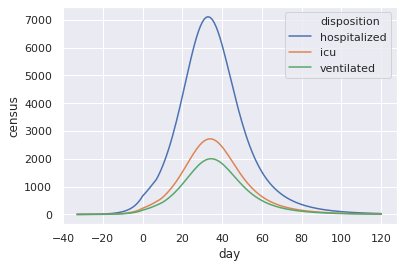

In [21]:
census_df = results['census_df']
census_long = pd.melt(census_df, 
  id_vars=['day', 'date'],
                       value_vars=['hospitalized', 'icu', 'ventilated'],
                       var_name='disposition', value_name='census')


sns.lineplot(x='day', y='census', hue='disposition', 
             data=census_long);

## Concluding remarks
Hopefully this helps clarify how CHIME is currently computing resource use. In the next notebook, I'll build on this and explore the implied arrival rates and ALOS values for subpopulations of patients such as those covid-19 patients who do NOT use ICU and those ICU patients who do NOT use a vent. These are simple algebraic computations and by feeding them back to users, might help people calibrate their inputs better.

<font size="2">This material is made available under the [MIT License](https://opensource.org/licenses/MIT).</font>